<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/HW2_Gradient_descent_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Домашнее задание: Градиентный спуск — продвинутая часть**

В этом домашнем задании вы ещё раз закрепите **градиентный спуск**, но уже в модифицированном виде.
Вы реализуете различные виды GD, закрепите на практике их свойства и улучшения и научитесь интерпретировать результаты.


**Дедлайн: 13 декабря 23:59**

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
import pandas as pd

np.random.seed(42)

### **Задание 1. Зоопарк оптимизаторов (5 баллов)**


Обычный градиентный спуск с постоянным шагом хорошо работает на простых выпуклых функциях, но резко теряет эффективность, как только ландшафт становится более сложным. В реальности ландшафт сложный всегда — если мы работаем с нейронной сетью — параметров много и функции сложные. В них есть разные проблемы (лучше, чем читать — посмотреть [здесь](https://losslandscape.com/gallery/)):

* узкие долины,
* сильно различающиеся масштабы по координатам,
* плоскости с почти нулевым градиентом,
* рябь, плоскости, седловые точки.

В таких ситуациях стандартный GD перестаёт справляться, поэтому в современной оптимизации почти никогда не используют голый вариант GD. Его заменяют **модифицированные методы**, которые:

* адаптируют шаг обучения под каждую координату,
* сглаживают траекторию накоплением информации о прошлых градиентах,
* корректируют скорость движения в зависимости от геометрии ландшафта.

В этом задании мы будем реализовывать такие методы в единой архитектуре.

#### **Задание 1.1 Реализация золотой пятерки (3 балла)**

Ниже в коде уже реализован общий базовый класс `Optimizer`, который:

* содержит цикл обучения (`fit`),
* считает градиенты,
* сохраняет историю оптимизации,
* контролирует количество итераций,
* передаёт параметры в оптимизатор.

Ваша задача, для каждого типа оптимизатора, реализовать метод:

```python
def step(self, params, gradient, iteration):
    ...
```

Он принимает, текущие параметры, текущий градиент, номер итерации и должен вернуть обновлённые параметры.


#### **Золотая пятерка**

0. **Vanilla Gradient Descent**
   $$w_{t+1} = w_t - \eta\nabla L(w_t)$$
   
   где $\eta$ — шаг обучения, $\nabla L(w_t)$ — градиент в точке $w_t$.

1. **Momentum (градиентный спуск с моментом)** —  накапливаем “скорость” (усреднённый градиент), чтобы сгладить траекторию и ускориться вдоль долины.
  $$v_t = \beta v_{t-1} + (1 - \beta)\nabla L(w_t)$$
  $$w_{t+1} = w_t - \eta v_t$$
   где $v_t$ — скорость, $\beta \in [0,1)$ — коэффициент затухания (часто 0.9).

2. **Nesterov Accelerated Gradient (NAG, ускоренный градиент Нестерова)** —  градиент вычисляется в точке, куда мы *ещё только собираемся сделать шаг*.

  $$v_t = \beta v_{t-1} + (1 - \beta) \nabla L(w_t)$$
  $$w_{t+1} = w_t - \eta \left( \beta v_t + (1 - \beta)\nabla L(w_t) \right)$$

3. **AdaGrad** — реализует адаптивный шаг обучения на основе накопления квадратов градиента. Идея такая — ксли по некоторой координате градиенты большие — по ней уменьшать шаг, а если градиенты маленькие → шаг остаётся большим.

$$G_t = G_{t-1} + (\nabla L(w_t))^2$$
$$\eta_t = \frac{\eta}{\sqrt{G_t+\varepsilon}}$$
$$w_{t+1} = w_t - \eta_t \nabla L(w_t)$$

где $\varepsilon$ — стабилизация — чтобы не делить на ноль.


4. **RMSprop** — экспоненциальное сглаживание квадратов градиента. Идея тут — убить недостаток AdaGrad —  онслишком быстро уменьшает шаг, поэтому RMSprop заменяет сумму экспоненциальным средним.

$$s_t = \beta s_{t-1} + (1 - \beta)(\nabla L(w_t))^2$$
$$\eta_t = \frac{\eta}{\sqrt{s_t + \varepsilon}}$$
$$w_{t+1} = w_t - \eta_t \nabla L(w_t)$$


5. **Adam** — Momentum + RMSprop одновременно. Идейно Adam поддерживает две экспоненциальные скользящие средние:

* $m_t$ — среднее градиентов (как momentum),
* $v_t$ — среднее квадратов градиентов (как RMSprop).

Кроме того, вводится коррекция смещения.

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1)\nabla L(w_t)$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2)(\nabla L(w_t))^2$$

$$\hat m_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat v_t = \frac{v_t}{1 - \beta_2^t}$$

$$w_{t+1} = w_t - \eta \frac{\hat m_t}{\sqrt{\hat v_t + \varepsilon}}$$



**Для каждого оптимизатора вы должны написать класс, наследуемый от `Optimizer`, и в нем метод `step()` ровно по формулам выше.
Без внешних библиотек, никаких упрощений. При этом:**


* Базовый класс `Optimizer` уже полностью готов, но в нем <font color="red">специально допущено несколько ошибок. Исправьте их.</font>
* Далее ваша задача — лишь реализовать формулы обновления весов в соответствующих классах.
* После реализации протестируйте оптимизаторы (это будет следующее задание).

In [ ]:
class Optimizer:
    """Базовый класс для оптимизаторов"""

    def __init__(self, learning_rate=0.01, n_iterations=100):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.history = {
            'params': [],
            'loss': [],
            'gradients': []
        }

    def step(self, params, gradient, iteration):
        """Один шаг оптимизации - должен быть переопределён"""
        raise NotImplementedError

    def fit(self, loss_fn, grad_fn, initial_params):
        params = initial_params.copy()

        for i in range(self.n_iterations):
            gradient = grad_fn(params)

            self.history['params'].append(params.copy())
            self.history['loss'].append(loss_fn(params))
            self.history['gradients'].append(gradient.copy())

            params = self.step(params, gradient, i)

        self.history['params'].append(params.copy())
        self.history['loss'].append(loss_fn(params))
        final_gradient = grad_fn(params)
        self.history['gradients'].append(final_gradient.copy())

        return params


class VanillaGD(Optimizer):
    """Обычный градиентный спуск"""

    def step(self, params, gradient, iteration):
        # Ваш код здесь
        return params - self.learning_rate * gradient


class MomentumGD(Optimizer):
    """GD с momentum"""

    def __init__(self, learning_rate=0.01, n_iterations=100, beta=0.9):
        super().__init__(learning_rate, n_iterations)
        self.beta = beta
        self.velocity = None

    def step(self, params, gradient, iteration):
        # Ваш код здесь
        if self.velocity is None:
            self.velocity = np.zeros(params.shape)
        self.velocity = self.beta * self.velocity + (1 - self.beta) * gradient
        return params - self.learning_rate * self.velocity
        

# Я немного тут запутался, потому что в телеграм чате было написано, что формула
# которая ваше неверна. Но ее решение мне понравилось и я ее оставил. 
# NesterovGD_guide - это из описания выше
# NesterovGD_telegram - с корректировкой из телеграм чата
 
class NesterovGD_guide(Optimizer):
    """Nesterov Accelerated Gradient"""

    def __init__(self, learning_rate=0.01, n_iterations=100, beta=0.9):
        super().__init__(learning_rate, n_iterations)
        self.beta = beta
        self.velocity = None

    def step(self, params, gradient, iteration):
        # Ваш код здесь
        if self.velocity is None:
            self.velocity = np.zeros(params.shape)
        self.velocity = self.beta * self.velocity + (1 - self.beta) * gradient
        params = params - self.learning_rate * (self.beta * self.velocity + (1 - self.beta) * gradient)
        return params

# Сразу скажу, что моя формула отличается от того, что скинуто было в телеграмме - потому что там есть w_hat
# но это бы потребовало сильному изменению класса, что я не решился сделать
class NesterovGD_telegram(Optimizer):
    """Nesterov Accelerated Gradient"""

    def __init__(self, learning_rate=0.01, n_iterations=100, beta=0.9):
        super().__init__(learning_rate, n_iterations)
        self.beta = beta
        self.velocity = None

    def step(self, params, gradient, iteration):
        # Ваш код здесь
        if self.velocity is None:
            self.velocity = np.zeros(params.shape)
        self.velocity = self.beta * self.velocity + gradient
        
        params = params - self.learning_rate * (self.beta * self.velocity + gradient)

        return params
    

class AdaGrad(Optimizer):
    """AdaGrad optimizer"""

    def __init__(self, learning_rate=0.01, n_iterations=100, epsilon=1e-8):
        super().__init__(learning_rate, n_iterations)
        self.epsilon = epsilon
        self.accumulated_grad = None

    def step(self, params, gradient, iteration):
        # Ваш код здесь
        if self.accumulated_grad is None:
            self.accumulated_grad = np.zeros(gradient.shape)
        self.accumulated_grad = self.accumulated_grad + (gradient) ** 2

        lr_new = self.learning_rate / (self.accumulated_grad + self.epsilon) ** 0.5

        return params - lr_new * gradient


class RMSprop(Optimizer):
    """RMSprop optimizer"""

    def __init__(self, learning_rate=0.01, n_iterations=100, beta=0.9, epsilon=1e-8):
        super().__init__(learning_rate, n_iterations)
        self.beta = beta
        self.epsilon = epsilon
        self.squared_grad = None

    def step(self, params, gradient, iteration):
        # Ваш код здесь
        if self.squared_grad is None:
            self.squared_grad = np.zeros(gradient.shape)

        self.squared_grad = self.beta * self.squared_grad + (1 - self.beta) * (gradient) ** 2
        lr_new = self.learning_rate / (self.squared_grad + self.epsilon) ** 0.5
        return params - lr_new * gradient
    
class Adam(Optimizer):
    """Adam optimizer"""

    def __init__(self, learning_rate=0.01, n_iterations=100, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate, n_iterations)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None

    def step(self, params, gradient, iteration):
        # Ваш код здесь
        if self.m is None:
            self.m = np.zeros(gradient.shape)
        if self.v is None:
            self.v = np.zeros(gradient.shape)

        iteration_new = iteration + 1  # чтобы не было деления на единицу

        self.m = self.beta1 * self.m + (1 - self.beta1) * gradient
        self.v = self.beta2 * self.v + (1 - self.beta2) * gradient ** 2

        m_cup = self.m / (1 - self.beta1 ** iteration_new)
        v_cup = self.v / (1 - self.beta2 ** iteration_new)

        params = params - self.learning_rate * m_cup / (v_cup + self.epsilon) ** 0.5

        return params



#### **Задание 1.2 Тестирование золотой пятерки (2 балла)**

Протестируем оптимизиторы на красивой двумерной функции — **функции Растригина (Rastrigin function)**. Почему именно она? На самом деле, существует несколько [популярных функций-тестов](https://en.wikipedia.org/wiki/Test_functions_for_optimization) для функций оптимизации. И все они безумно красивые. Просто эта — [особенно хорошо отражает сложные ландшафты](https://en.wikipedia.org/wiki/Rastrigin_function). Она имеет:

* большое число локальных экстремумов,
* регулярную рябь по всей области,
* хорошо выраженный глобальный минимум.

Её аналитическая форма в двумерном случае:

$$f(x, y) = 20 + x^2 + y^2 - 10(\cos(2\pi x) + \cos(2\pi y))$$

Глобальный минимум:

$$(x^*, y^*) = (0,0), \quad f(x^*, y^*) = 0.$$


**Что сделать в задании:**
1. Реализовать функцию (двумерную) и ее градиент

2. Запустить каждый оптимизатор:

   * записать функцию и её градиент;
   * запустить оптимизиторы из данной стартовой точки (она прописана в коде), с прописанным базовым learning rate.

3. Для каждого метода вывести:

   * итоговые значения аргументов $x$ и $y$,
   * финальное значение функции потерь.


4. Сделать краткий анализ. Можно опираться на вопросы:

   * Какие методы сходятся быстрее?
   * Кто застрял в локальных минимумах?
   * Насколько траектории “дрожат”?
   * Как адаптивные методы корректируют шаг?
   * Какие методы вышли ближе всего к глобальному минимуму?

### Ответ:

#### 1. Какие методы сходятся быстрее?
Наибольшую скорость уменьшения функции продемонстрировали Adam, Momentum и AdaGrad и их финальный loss оказался минимальным. Они быстрее других вышли в область локального минимума.  
GD, NAG_telegram сходились медленно и в итоге ушли куда-то далеко.  
NAG_guide показал среднюю скорость и пришёл в точку, не близкую к минимуму.  

#### 2. Кто застрял в локальных минимумах?
Ни один метод не достиг глобального минимума. **Я поигрался с learning_rate, и нашел что при значении 0.5 Adam достигает глобального минимума.**    
Методы Momentum, AdaGrad, RMSprop и Adam сошлись к одному и тому же локальному минимуму около (-1,2).  
NAG_guide оказался близко, но его итоговая точка немного отличается.  
GD застряли в других локальных далеко от глобального минимума.
NAG_telegram ушел дальше, чем GD.

#### 3. Насколько траектории “дрожат”?
Траектория GD и NAG_telegram были наиболее "дрожащими" с крупными шагами.  
У NAG_guide есть некая осцилляции (10 лет прошло с того момента, как я получил диплом по квантовой физики и наконец-то мне это слово пригодилось).
Так же заметная слабая осцилляция у RMSprop.    
Методы AdaGrad, Моmentum и Adam двигались более плавно.

#### 4. Как адаптивные методы корректируют шаг?
AdaGrad быстро уменьшает шаг, но может рано замедляться.  
RMSprop поддерживает более постоянный шаг, что может помочь в сложных ландшафтах.  
Adam демонстрируя наиболее сбалансированное и быстрое движение.

#### 5. Какие методы вышли ближе всего к глобальному минимуму?
Adam, AdaGrad, Momentum, RMSprop и NAG_guide попали в ловушку локального минимума и поэтому при данных значениях никто в глобальный минимум не попал. Для попадание в глобальный минимум, как я уже и упоминал, можно поменять learning_rate. 
GD и NAG_telegram вообще далеки от правильного места.

**Ваш анализ здесь**
1. Чего не хватило адаптивным методам? Что с ними произошло?
2. Почему градиетному спуску так плохо?

### Ответ:

#### Чего не хватило адаптивным методам? Что с ними произошло?
Адаптивные методы корректируют шаг по каждой координате автоматически, но на функции Растригина у них возникает большая проблема - они слишком хорошо адаптируются по локацию, где находятся. Около локального минимума их градиенты становятся слишком маленькими и они перестают двигаться дальше. И из-за этого они не могут "перепрыгнуть" через локальные выпуклости. При больших значениях lerning_rate можно их перепругнуть, но для этого надо сидеть и подбирать эти значения.

#### Почему градиетному спуску так плохо?
Градиентному спуску плохо, потому что он использует один фиксированный шаг и не умеет адаптироваться под геометрию вот такой дрожащей функции. Градиентный спуск начинает сильно прыгать и отскакивать от локальных минимумов. Вместо стабилизации он перелетает через оптимумы и уходит всё дальше от глобального минимума.


### **Задание 2. Анализ Losses (2 балла)**



В реализации базового класса `Optimizer`, при каждом спуске сохраняются графики loss-функции. Их в процессе обучения мы также анализируем. Напомним, что говорят, что **loss “сходится”**, если выполняются следующие признаки:

1. Значение loss $L(w_k)$ монотонно убывает и приближается к некоторому предельному значению (выходит на плато):
   $$|L(w_{k+1}) - L(w_k)| \to 0$$

Сошелся ли лосс у нас? Используйте ваши реализации из заданий 1–2:

1. Постройте графики значения loss, проанализируйте, какие спуски сошлись.
2. Поизменяйте learning rate, обучите спуски ещё и снова выведите лосс. Как learning rate влияет на результат и удалось ли сойтись теперь?

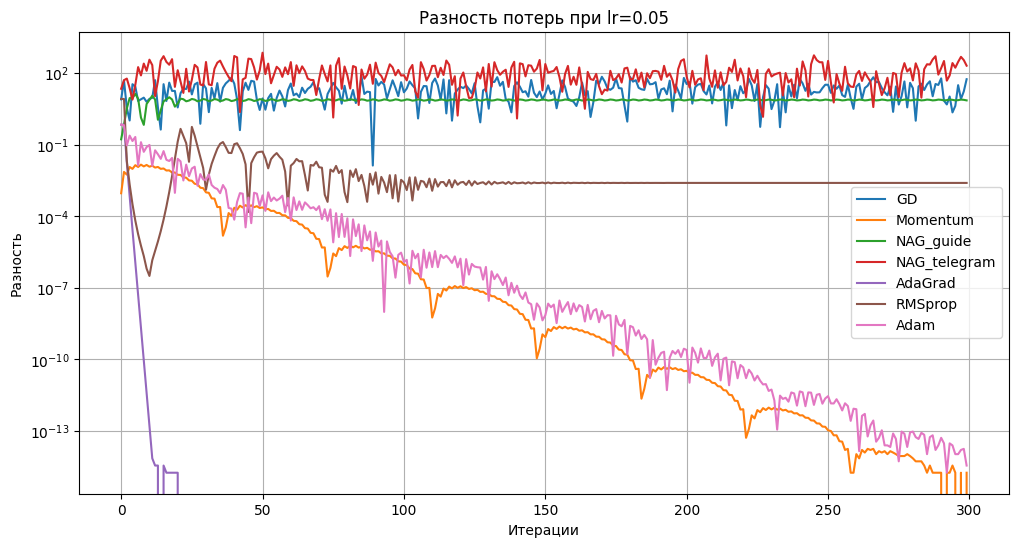

In [72]:
# Ваш код здесь
def diff_loss(history):
    loss_hist = history["loss"]
    diff_list = []
    for i in range(len(loss_hist) - 1):
        diff_list.append(abs(loss_hist[i + 1] - loss_hist[i]))
    return diff_list

def loss_experiment(lr, n_iter=300):

    optimizers = {
        'GD':       VanillaGD(learning_rate=lr, n_iterations=n_iter),
        'Momentum': MomentumGD(learning_rate=lr, n_iterations=n_iter, beta=0.9),
        'NAG_guide': NesterovGD_guide(learning_rate=lr, n_iterations=n_iter, beta=0.9),
        'NAG_telegram': NesterovGD_telegram(learning_rate=lr, n_iterations=n_iter, beta=0.9),
        'AdaGrad':  AdaGrad(learning_rate=lr, n_iterations=n_iter),
        'RMSprop':  RMSprop(learning_rate=lr, n_iterations=n_iter, beta=0.9),
        'Adam':     Adam(learning_rate=lr, n_iterations=n_iter)
    }

    loss_diff_dict = {}

    for name, optimizer in optimizers.items():
        optimizer.fit(rastrigin_function, rastrigin_gradient, initial_point)
        diffs = diff_loss(optimizer.history)
        loss_diff_dict[name] = diffs

    return loss_diff_dict

def plot_loss_diffs(results, lr):
    plt.figure(figsize=(12, 6))
    for name, diffs in results.items():
        plt.plot(diffs, label=name)
    plt.xlabel("Итерации")
    plt.ylabel("Разность")
    plt.title(f"Разность потерь при lr={lr}")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

loss_diff_dict = loss_experiment(0.05)
plot_loss_diffs(loss_diff_dict, 0.05)

In [73]:
def experiment(lr, n_iter=300):

    optimizers = {
        'GD':       VanillaGD(learning_rate=lr, n_iterations=n_iter),
        'Momentum': MomentumGD(learning_rate=lr, n_iterations=n_iter, beta=0.9),
        'NAG_guide': NesterovGD_guide(learning_rate=lr, n_iterations=n_iter, beta=0.9),
        'NAG_telegram': NesterovGD_telegram(learning_rate=lr, n_iterations=n_iter, beta=0.9),
        'AdaGrad':  AdaGrad(learning_rate=lr, n_iterations=n_iter),
        'RMSprop':  RMSprop(learning_rate=lr, n_iterations=n_iter, beta=0.9),
        'Adam':     Adam(learning_rate=lr, n_iterations=n_iter)
    }

    loss_dict = {}

    for name, optimizer in optimizers.items():
        optimizer.fit(rastrigin_function, rastrigin_gradient, initial_point)
        losses = optimizer.history["loss"]
        loss_dict[name] = losses

    return loss_dict

def plot_loss(results, lr):
    plt.figure(figsize=(12, 6))
    for name, losses in results.items():
        plt.plot(losses, label=name)
    plt.xlabel("Итерации")
    plt.ylabel("Loss")
    plt.title(f"Изменение Loss при lr={lr}")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()



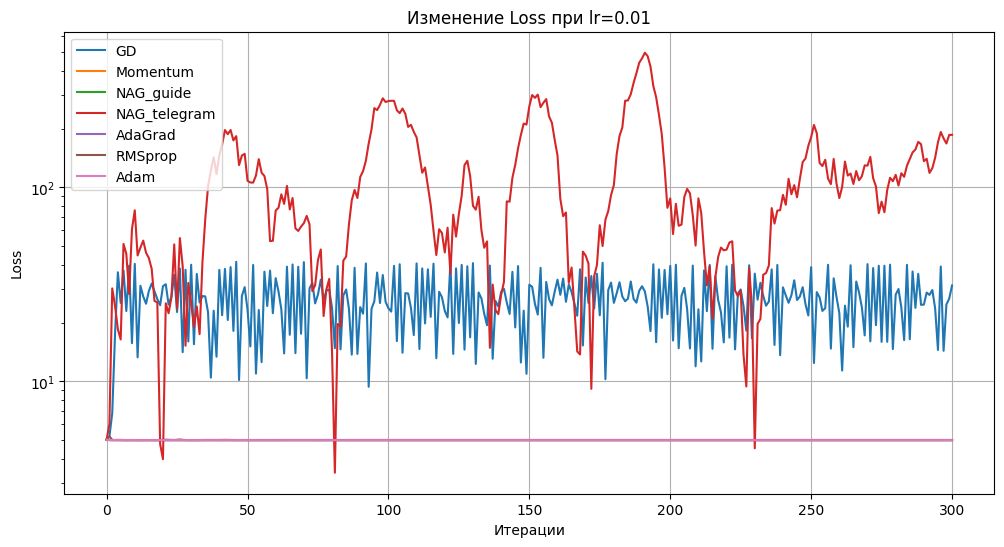

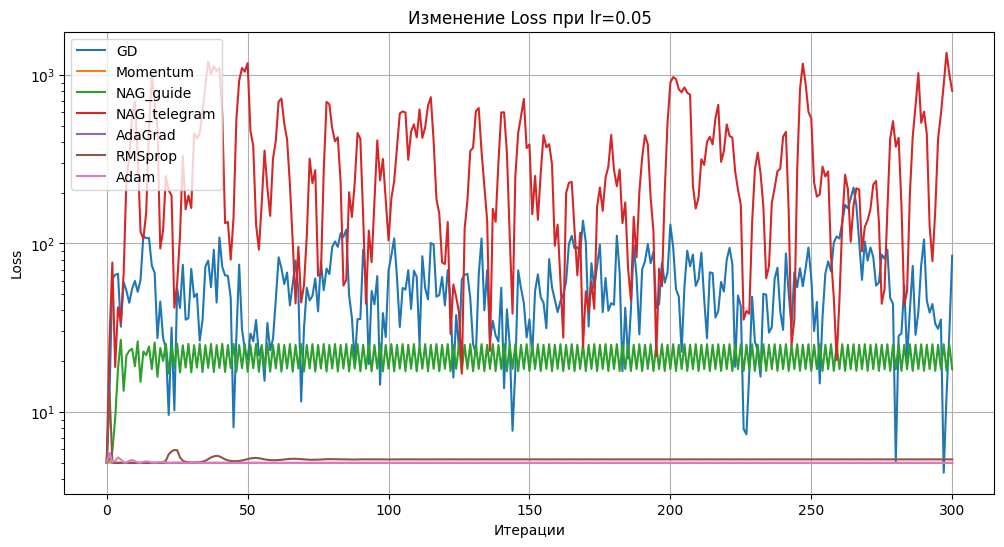

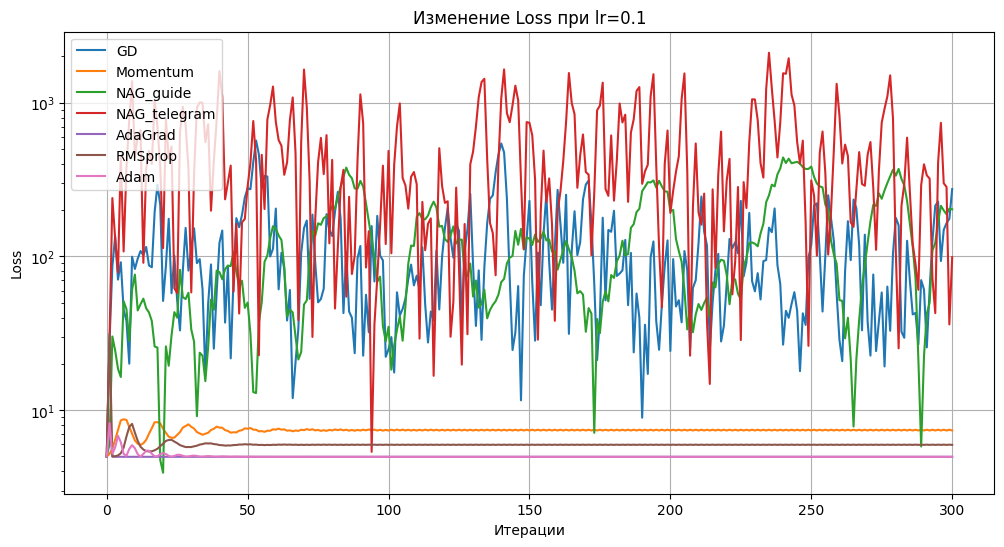

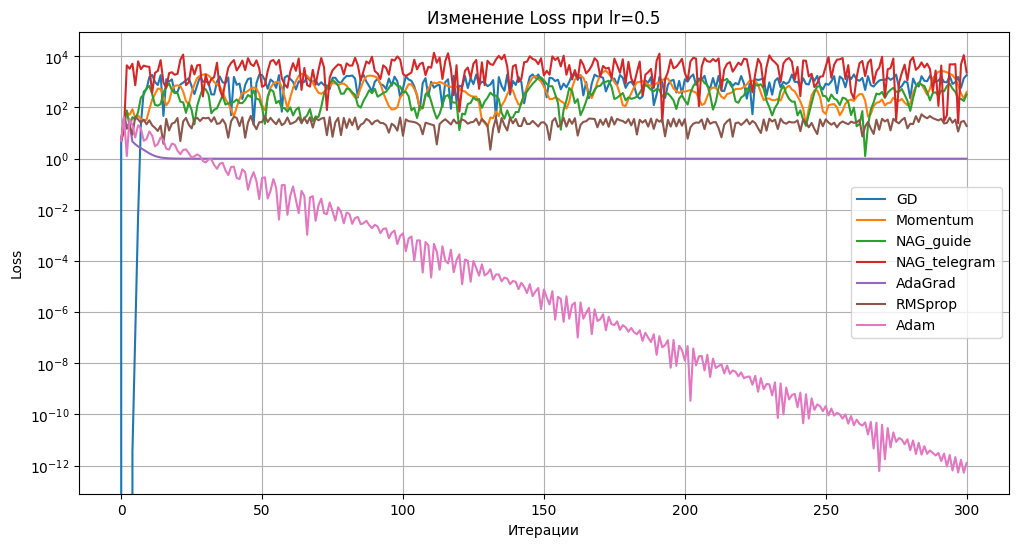

In [74]:
learning_rates = [0.01, 0.05, 0.1, 0.5]

for lr in learning_rates:
    loss_dict = experiment(lr)
    plot_loss(loss_dict, lr)


### Ответ:

#### Как learning rate влияет на результат и удалось ли сойтись теперь?


1. GD и NAG_telegram
Практически не реагируют на изменение learning rate.  
Они как не могли найти минимум, так и осталось. 

2. Momentum и NAG_guide
При малых lr работают заметно лучше GD и пытаются ускориться вдоль оптимального направления,  
но при увеличении lr до 0.5 и выше методы становятся нестабильными и начинают вести себя почти так же плохо, как и обычный GD и шаги становятся слишком крупными.

3. RMSprop
Показывает хорошие результаты при lr <= 0.1, аккуратно снижая loss.  
Однако при lr = 0.5 метод теряет устойчивость и появляется осцилляция и модель уже не сходится.

4. AdaGrad
Поведение на всех lr стабильное метод быстро спускается, уменьшает шаги и всегда приходит в один и тот же локальный минимум.  

5. Adam
Единственный оптимизатор, который при lr = 0.5 смог выйти из локальной ловушки и приблизиться к глобальному минимуму.  

### **Задание 3. Будь выпуклым (3 балла)**



На протяжении курса вы могли заметить, что мы всегда предпочитаем выпуклые функции потерь. Но насколько это требование жесткое? Давайте рассмотрим простейшую логистическую регрессию.

Модель:

$$p(x; w) = \sigma(z) = \sigma(w^\top x), \quad \sigma(z) = \frac{1}{1 + e^{-z}}.$$

Стандартный log-loss для одного объекта:

$$L_{\log}(p, y) = -\big( y \log p + (1-y)\log(1-p)\big), \quad y \in {0, 1}.$$

Рассмотрим для неё модифицированный loss — без логарифма. Просто опустим его, оставив линейную комбинацию вероятностей.

$$L_{\text{no-log}}(p, y) = -\big( y p + (1-y)(1-p)\big)$$


#### **3. 1. Логарифм? (2 балла)**

Попробуем понять, зачем вообще нам нужен логарифм.

1. Выведите производную logloss'a  без логарифма по $p$ **(только по $p$, по $w$ не надо!)**. Что получилось? Подумайте (погуглите), почему на практике используют логарифм.

2. Сравните качество:

   * обучите логистическую регрессию с обычным log-loss,
   * обучите с модифицированным loss без log,
   * сравните качество моделей. Поясните результаты.

  **В функциях градиенты должны быть уже по W**


### Ответ:

1. Взял на бумажке производную по $p$. Получилось $\frac{\partial L}{\partial p} = 1 - 2y$. То есть видно, что первая производная уже не зависит от $p$, а значит сама модель всегда движется с одним шагом не зависимо от результатов предсказания. Если у нас будет логарифм, то беря сложную производную у нас доявиться в ней $p$ и поэтому будет корректироваться в зависимости от результатов.

In [75]:
# Генерация данных
X_class, y_class = make_classification(
    n_samples=1000,
    n_features=30,
    n_informative=20,
    random_state=42
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_class)
X_with_bias = np.column_stack([np.ones(len(X_scaled)), X_scaled])  # добавляем bias-столбец


# Функции для лосса
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Стандартный логистический log-loss
def logistic_loss(weights, X, y):
    """
    L_log(w) = - mean( y log p + (1-y) log(1-p) ),  p = sigmoid(X w)
    """
    # Ваш код здесь
    p = sigmoid(X @ weights)
    L_log = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    return L_log


def logistic_gradient(weights, X, y):
    """
    grad_w L_log(w) = X^T (p - y) / N,  где p = sigmoid(X w)
    """
    # Ваш код здесь
    p = sigmoid(X @ weights)
    grad_w = X.T @ (p - y) / len(y)
    return grad_w

def without_log_loss(weights, X, y):
    """
    Log-loss без логарифма"
        L_no_log(w) = - mean( y p + (1 - y)(1 - p) ), p = sigmoid(X w)
    """
    # Ваш код здесь
    p = sigmoid(X @ weights)
    L_no_log = - np.mean(y * p + (1 - y) * (1 - p))
    return L_no_log


def without_log_loss_grad(weights, X, y):
    """
    Градиент L_no_log по w:
        dL/dp = 1 - 2y
        dp/dz = p (1-p)
        z = X w

    grad_w L_no_log = X^T * [ (1 - 2y) * p (1-p) ] / N
    """
    # Ваш код здесь
    p = sigmoid(X @ weights)

    dL_dp = 1 - 2 * y
    dp_dz = p * (1 - p)
    dL_dz = dL_dp * dp_dz

    grad_w_L_no_log = (X.T @ dL_dz) / len(y)
    return grad_w_L_no_log
    

Проверим результаты.

* далее везде используйте окласс оптимизатора (`VanillaGD`) и одинаковую инициализацию весов;
* для каждой модели реализуйте свои `loss_fn` и `grad_fn` и передайте их в `fit` через `lambda`:

  ```python
  gd_log = VanillaGD(...)
  w_log = gd_log.fit(
      loss_fn=lambda w: logistic_loss(w, X_with_bias, y),
      grad_fn=lambda w: logistic_gradient(w, X_with_bias, y),
      initial_params=initial_weights
  )
  ```

  и аналогично для `no_log_loss` / `no_log_loss_grad`. Так всё заработает.


In [76]:
initial_weights = np.ones(X_with_bias.shape[1])

# Логистическая регрессия с log-loss
gd_log = VanillaGD(learning_rate=0.5, n_iterations=200)
w_log = gd_log.fit(
    loss_fn=lambda w: logistic_loss(w, X_with_bias, y_class),
    grad_fn=lambda w: logistic_gradient(w, X_with_bias, y_class),
    initial_params=initial_weights
)

# Логистическая регрессия с no-log loss
gd_no = VanillaGD(learning_rate=0.5, n_iterations=200)
w_no = gd_no.fit(
    loss_fn=lambda w: without_log_loss(w, X_with_bias, y_class),
    grad_fn=lambda w: without_log_loss_grad(w, X_with_bias, y_class),
    initial_params=initial_weights
)

def accuracy(weights):
    p = sigmoid(X_with_bias @ weights)
    y_pred = (p >= 0.5).astype(int)
    return (y_pred == y_class).mean()

print("\n=== Итоговые результаты (VanillaGD) ===")
print(f"log-loss:    final_loss = {logistic_loss(w_log, X_with_bias, y_class):.4f}, "
      f"accuracy = {accuracy(w_log):.4f}")
print(f"no-log loss: final_loss = {without_log_loss(w_no, X_with_bias, y_class):.4f}, "
      f"accuracy = {accuracy(w_no):.4f}")



=== Итоговые результаты (VanillaGD) ===
log-loss:    final_loss = 0.3976, accuracy = 0.8110
no-log loss: final_loss = -0.7195, accuracy = 0.7330


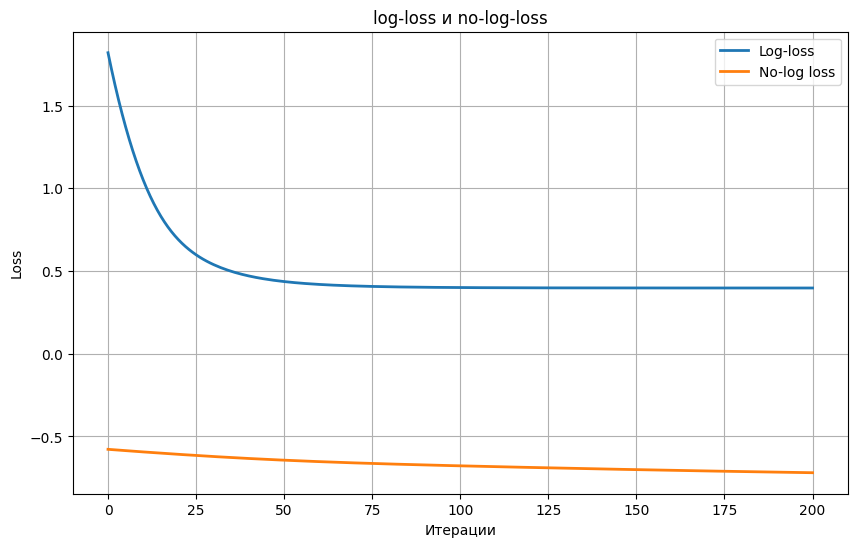

In [79]:
# ваш код здесь — постройте график лосса
plt.figure(figsize=(10, 6))

plt.plot(gd_log.history["loss"], label="Log-loss", linewidth=2)
plt.plot(gd_no.history["loss"], label="No-log loss", linewidth=2)

plt.xlabel("Итерации")
plt.ylabel("Loss")
plt.title("log-loss и no-log-loss")
plt.grid(True)
plt.legend()
plt.show()


### Ответ:

2. 
Модель с log-loss имеет хорошие показатели, лосс снижается ожидаемым образом и получается accuracy = 0.8110.
log-loss сильно штрафует ошибки, поэтому градиент даёт модели правильное направление

Модель с no-log loss демонстрирует более низкую accuracy = 0.7330, хотя сам лосс тоже уменьшается.  
Но снижается он не очень. Градиент не зависит от того, насколько уверенно модель ошибается, поэтому веса обновляются почти одинаково в любых ситуациях. В итоге модель не получает информации о том, какие ошибки важнее, и обучение получается слабым.

#### **3. 2. И снова анализ (1 балл)**

Подумайте над результатами задания.
- Почему no-log выдал меньший loss? Значит ли это, что мы можем его использовать?
- Что будет, если подобрать гиперпараметр скорости спуска и попробовать другие оптимизаторы?

Реализуйте ваши эксперименты. За каждый — 0.5 балла (суммарно максимум 1 балл).

### Ответ

#### Почему no-log дал меньший loss?
Потому что это совсем другая шкала. Его значения всегда лежат примерно в диапазоне от –1 до 0, поэтому loss автоматически получается “меньше”. Это не означает, что модель обучилась лучше.

### Можно ли использовать no-log?  
Нет. Его градиенты почти исчезают при больших и малых вероятностях и модель перестаёт учиться. Итоговая accuracy ниж.

#### Что будет при подборе learning rate и других оптимизаторов?  
- log-loss будет работать нормально и улучшать качество.  
- no-log может сходиться быстрее или медленнее, но качество всё равно остаётся плохим так как проблема в самой форме лосса.


In [102]:
lrs = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100]

for lr in lrs:
    opt = VanillaGD(learning_rate=lr, n_iterations=300)
    w_tmp = opt.fit(
        loss_fn=lambda w: without_log_loss(w, X_with_bias, y_class),
        grad_fn=lambda w: without_log_loss_grad(w, X_with_bias, y_class),
        initial_params=initial_weights
    )

    print(f"lr={lr}: final_loss={without_log_loss(w_tmp, X_with_bias, y_class):.4f}, "
          f"accuracy={accuracy(w_tmp):.4f}")

lr=0.001: final_loss=-0.5790, accuracy=0.5780
lr=0.01: final_loss=-0.5875, accuracy=0.5830
lr=0.1: final_loss=-0.6524, accuracy=0.6640
lr=0.5: final_loss=-0.7472, accuracy=0.7550
lr=1.0: final_loss=-0.7895, accuracy=0.8040
lr=5.0: final_loss=-0.8218, accuracy=0.8380
lr=10.0: final_loss=-0.8302, accuracy=0.8480
lr=50: final_loss=-0.8384, accuracy=0.8500
lr=100: final_loss=-0.8409, accuracy=0.8480


### Вывод

При использовании no-log-loss качество модели заметно улучшается при увеличении learning_rate. На маленьких lr градиенты слишком слабые, обучение почти не движется. Когда lr становится достаточно большим (0.5–10), модель начинает обучаться, и accuracy растёт. После lr = 10 наступает насыщение: дальнейшее увеличение lr не даёт существенной выгоды.  

In [105]:
lrs = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100]
print("\n=== Итоговые результаты ===")
for lr in lrs:
    optimizers_test = {
        "GD":       VanillaGD(learning_rate=lr, n_iterations=300),
        "Momentum": MomentumGD(learning_rate=lr, n_iterations=300, beta=0.9),
        "RMSprop":  RMSprop(learning_rate=lr, n_iterations=300),
        "Adam":     Adam(learning_rate=lr, n_iterations=300)
    }
    print(f"\n=== learning_rate = {lr} ===")
    for name, opt in optimizers_test.items():
        w_tmp = opt.fit(
            loss_fn=lambda w: without_log_loss(w, X_with_bias, y_class),
            grad_fn=lambda w: without_log_loss_grad(w, X_with_bias, y_class),
            initial_params=initial_weights
        )
        print(f"{name:10s}: final_loss = {without_log_loss(w_tmp, X_with_bias, y_class):.4f}, "
                f"accuracy={accuracy(w_tmp):.4f}")


=== Итоговые результаты ===

=== learning_rate = 0.001 ===
GD        : final_loss = -0.5790, accuracy=0.5780
Momentum  : final_loss = -0.5789, accuracy=0.5780
RMSprop   : final_loss = -0.6463, accuracy=0.6650
Adam      : final_loss = -0.6441, accuracy=0.6630

=== learning_rate = 0.01 ===
GD        : final_loss = -0.5875, accuracy=0.5830
Momentum  : final_loss = -0.5873, accuracy=0.5830
RMSprop   : final_loss = -0.8059, accuracy=0.8370
Adam      : final_loss = -0.7896, accuracy=0.8150

=== learning_rate = 0.1 ===
GD        : final_loss = -0.6524, accuracy=0.6640
Momentum  : final_loss = -0.6511, accuracy=0.6610
RMSprop   : final_loss = -0.8413, accuracy=0.8490
Adam      : final_loss = -0.8341, accuracy=0.8450

=== learning_rate = 0.5 ===
GD        : final_loss = -0.7472, accuracy=0.7550
Momentum  : final_loss = -0.7444, accuracy=0.7550
RMSprop   : final_loss = -0.8456, accuracy=0.8490
Adam      : final_loss = -0.8450, accuracy=0.8500

=== learning_rate = 1.0 ===
GD        : final_loss 

/var/folders/4j/kkrj4lbs6cxbqbq_dwpjj1dh0000gn/T/ipykernel_81390/2783416693.py:16: RuntimeWarning:

overflow encountered in exp



GD        : final_loss = -0.8302, accuracy=0.8480
Momentum  : final_loss = -0.8261, accuracy=0.8390
RMSprop   : final_loss = -0.8070, accuracy=0.8070
Adam      : final_loss = -0.8250, accuracy=0.8250

=== learning_rate = 50 ===
GD        : final_loss = -0.8384, accuracy=0.8500
Momentum  : final_loss = -0.8344, accuracy=0.8440
RMSprop   : final_loss = -0.7100, accuracy=0.7100
Adam      : final_loss = -0.7560, accuracy=0.7560

=== learning_rate = 100 ===
GD        : final_loss = -0.8409, accuracy=0.8480
Momentum  : final_loss = -0.8436, accuracy=0.8530
RMSprop   : final_loss = -0.6870, accuracy=0.6870
Adam      : final_loss = -0.7451, accuracy=0.7450


### Вывод
GD и Momentum ведут себя почти одинаково и улучшаются при увеличении lr.

Adam и RMSprop на малых lr обучаются лучше остальных, но при lr > 5 их преимущества исчезают они начинают переобучаться.

**Лучшее качество среди всех экспериментов — accuracy = 0.8530**, достигается у Momentum  при lr = 100.

При слишком больших lr (50, 100)
   - RMSprop и Adam резко становится хуже,
   - GD и Momentum выглядят лучше, но лишь потому, что loss no-log почти плоский и не штрафует за неправильные классификации.

## **Бонус 0.25 балла**

Проанализируйте график лосс-функции ниже. Попробуйте сформулировать гипотезы:
- Что происходит?
- Что с этим делать?


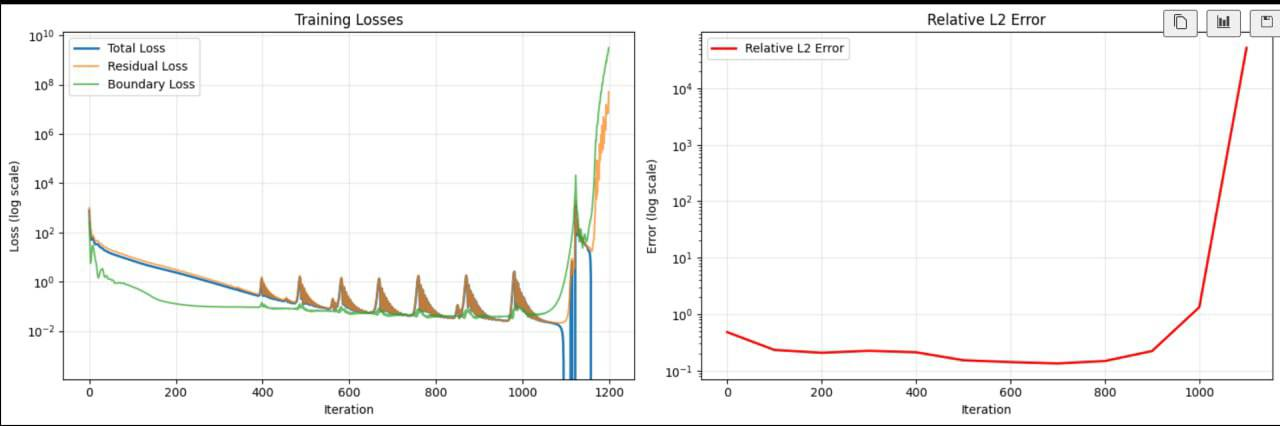

### Ответ:

Судя по графику, до 400 итераций обучение идёт стабильно: Total Loss и компоненты уменьшаются, а Relative L2 Error тоже падает. Но после 400–500 итераций начинаются периодические всплески, а ближе к 800 резкий рост ошибки на несколько порядков. 

Периодические пики похожи на то, что оптимизатор перескакивает через минимум и попадает в область с огромным градиентом возникает взрыв градиента.

Часто появляются такие колебания при долгом обучении, особенно если lr не снижать.

На мой взгляд early stopping решает эту проблему, чтобы оптимальное значение достигалось раньше, чем заканчивалось обучение.